In [1]:
import pymongo
from pymongo import MongoClient
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import csv
from sklearn import preprocessing
from nbi1 import *

import warnings
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.factorplots import interaction_plot
from scipy import stats

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

warnings.filterwarnings('ignore')
                        

In [2]:
def eta_squared(aov):
    aov['eta_sq'] = 'NaN'
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    return aov
 
def omega_squared(aov):
    mse = aov['sum_sq'][-1]/aov['df'][-1]
    aov['omega_sq'] = 'NaN'
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*mse))/(sum(aov['sum_sq'])+mse)
    return aov

def undersample(df, keyword):
    """
    It will take a dataframe and a keyword to groupby
    :input: df: Dataframe
            Key-word: column to groupby
            
    :return: undersample_df: Datafram
    
    """
    groupby_df = df.groupby([keyword]).count()
    count = min(groupby_df[groupby_df.columns[0]].tolist())
    
    tempdf_list = []

    for index in df[keyword].unique():
        tempdf_list.append(df[df[keyword] == index].sample(count)) ## Count
    
    undersample_df = pd.concat(tempdf_list)
    
    return undersample_df

def aov(df, formula):
    """
    :input: df: DataFrame
            formula: 
    
    :return: 
            Table
    """  
    model = ols(formula, df).fit()
    aov_table = anova_lm(model, typ=2)

    eta_squared(aov_table)
    return omega_squared(aov_table)
    
def createDictionary(dataframe_col1, dataframe_col2):
    """
    returns dictionary of structure number as key and and list of attribute belonging  to structure number
    :rtype: dictionary
    
    """
    # initialize the dictionary
    dictionary = {structure_number:[] for structure_number in dataframe_col1}
    
    for structure_number, value in zip(dataframe_col1, dataframe_col2):
        dictionary[structure_number].append(value)
    return dictionary


def createDictionaryOfMeanValue(dictionary):
    """
    returns dictionary of structure number as key and and mean values in corresponding to the structure number
    :rtype: dictionary
    
    """
    dictionary_new = {}
    
    for key, value in dictionary.items():
        mean_value = np.mean(value)
        dictionary_new[key] = mean_value
        
    return dictionary_new

def createDictionaryOfFirstValue(dictionary):
    dictionary_new = {}
    
    for key, value in dictionary.items():
        value = value[0]
        dictionary_new[key] = value
        
    return dictionary_new


### Importing dataset

In [3]:
df_csv = pd.read_csv('../data-generation/NE_Counties_MERRA_by_bridge.csv', index_col=0)
d_structureNumber_county = createDictionary(df_csv['structure_number'],df_csv['COUNTY_NAME'])
d_structureNumber_freeze_thaw = createDictionary(df_csv['structure_number'],df_csv['NO_OF_FREEZE_THAW_CYCLES'])

### Dataset

In [4]:
df_csv.head(10)

,structure_number,county_code,COUNTY_NAME,year,NO_OF_FREEZE_THAW_CYCLES,no_of_snowfalls
state_code,,,,,,
31,C000100305P,1.0,Adams County,1980.0,115.0,57.0
31,C000100305P,1.0,Adams County,1981.0,101.0,33.0
31,C000100305P,1.0,Adams County,1982.0,105.0,56.0
31,C000100305P,1.0,Adams County,1983.0,99.0,88.0
31,C000100305P,1.0,Adams County,1984.0,133.0,68.0
31,C000100305P,1.0,Adams County,1985.0,99.0,62.0
31,C000100305P,1.0,Adams County,1986.0,112.0,36.0
31,C000100305P,1.0,Adams County,1987.0,113.0,46.0
31,C000100305P,1.0,Adams County,1988.0,112.0,43.0


### Creating a dictionary

In [6]:
d_freeze_thaw = createDictionaryOfMeanValue(d_structureNumber_freeze_thaw)

In [32]:
d_county = createDictionaryOfFirstValue(d_structureNumber_county)

### Importing NBI data

In [7]:
csv_file = "../data-generation/04-28-19-thesis-dataset-without-outliers_allstates"
df_wo = pd.read_csv(csv_file, index_col = 0)

### Data Preprocessing

In [8]:
df_wo = df_wo[df_wo['No Change structure length'] == True]
df_wo = df_wo[~df_wo['Structure Length'].isin([-1,0, ])]
df_wo = df_wo[df_wo['Structure Length']>6]

In [9]:
NE = df_wo[df_wo['State Code'] == 31]
NE['SN'] = [structureNumber[:-2] for structureNumber in NE['Structure Number']]
NE['No. of Freeze Thaw'] = NE['SN'].map(d_freeze_thaw) 
NE_clean = NE.dropna()

In [10]:
NE_clean.shape

(8859, 30)

## Data visualization 

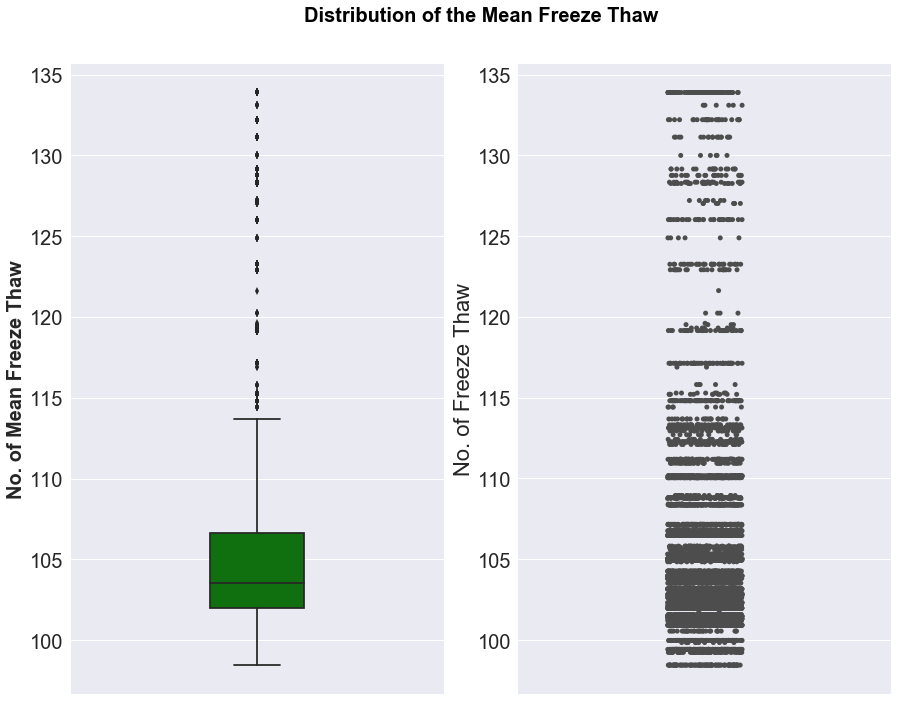

In [11]:
plt.figure(figsize=(12,10))
plt.subplots_adjust(bottom=0.025, left=0.025, top = 0.9, right=0.975)
plt.suptitle("Distribution of the Mean Freeze Thaw", fontsize = 20, fontweight = 'bold')
sns.set(font_scale=2)
plt.subplot(1,2,1)
sns.boxplot(x = NE_clean['No. of Freeze Thaw'],  color = 'Green', orient='v', width = 0.25)
plt.ylabel("No. of Mean Freeze Thaw", fontsize = 20, fontweight = "bold")

plt.subplot(1,2,2)
sns.stripplot(y= NE_clean['No. of Freeze Thaw'], jitter=True, color=".3")
plt.show()


In [12]:
NE_clean['freezethaw'] = pd.qcut(NE_clean['No. of Freeze Thaw'],[0, .05, .95, 1.], labels = ['Very Low','Medium','Very High'])

df_anova = NE_clean[['Baseline Difference Score', 'ADT Category','ADTT Category','Avg. Daily Precipitation', 'State Code',
                       'Material','Structure Type', 'Maintainer','freezethaw', 'No. of Freeze Thaw', 'Average ADT']]


df_anova = df_anova.rename(index=str, columns={"Baseline Difference Score": "score", \
                                               "ADT Category": "adt", \
                                               "ADTT Category": "adtt",\
                                               "Avg. Daily Precipitation": "precp", \
                                               "State Code":"region", \
                                               "Material":"material",\
                                               "Structure Type":"structuretype",\
                                               "Maintainer":"maintainer",\
                                               'freezethaw':'freezethaw',\
                                               'No. of Freeze Thaw':'numfreezethaw',
                                               'Average ADT':'aadtt'
                                               
                                              })

### Number of records after removing outliers 

In [13]:
df_anova.shape


(8859, 11)

### Bar chart

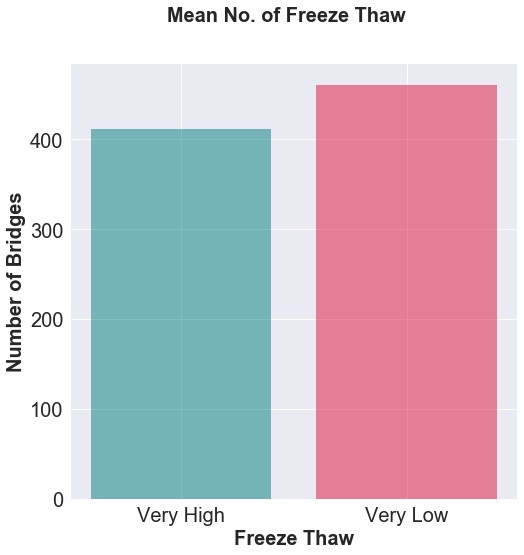

In [14]:
count_freezethaw = df_anova.groupby('freezethaw')['score'].count()

# Plotting 
plt.figure(figsize=(8,8))
plt.suptitle("Mean No. of Freeze Thaw", fontsize = 20, fontweight = 'bold')
sns.set(font_scale=2)

#Subplot 1
labels = ["Very Low", "Very High"]
no_of_records = [count_freezethaw[0], count_freezethaw[2]]
plt.bar(labels, no_of_records, align = 'center', alpha = 0.5, color = ['crimson','teal'])
plt.xticks(size = 20, rotation = 0)
plt.yticks(size = 20)
plt.xlabel("Freeze Thaw", fontweight = 'bold', fontsize = 20)
plt.ylabel("Number of Bridges", fontweight = 'bold', fontsize = 20)
plt.show()


In [15]:
df_anova['materialname'] = retMaterialNames(df_anova['material'])
df_anova = df_anova[df_anova['materialname'].isin(["Wood or Timber","Concrete", "Steel","Prestressed Concrete"])]

### Five point summary of the very high freeze thaw of the bridges in the Nebraska

In [16]:
df_anova[df_anova['freezethaw'] == 'Very High']['numfreezethaw'].describe()

count    300.000000
mean     128.408596
std        5.237719
min      119.157895
25%      123.263158
50%      128.763158
75%      133.894737
max      133.894737
Name: numfreezethaw, dtype: float64

### Five point summary of the very low freeze thaw of the bridges in the Nebraska

In [17]:
df_anova[df_anova['freezethaw'] == 'Very Low']['numfreezethaw'].describe()

count    338.000000
mean      99.425646
std        0.615778
min       98.447368
25%       99.236842
50%       99.421053
75%       99.973684
max      100.552632
Name: numfreezethaw, dtype: float64

### Small sample analysis

In [18]:
freezethaw_small = df_anova.groupby('freezethaw').apply(lambda s: s.sample(100))
freezethaw = df_anova.groupby('freezethaw').apply(lambda s: s.sample(100))['freezethaw'].tolist()
score = df_anova.groupby('freezethaw').apply(lambda s: s.sample(100))['score'].tolist()
df_freezethaw_sample_100 = pd.DataFrame({'freezethaw':freezethaw, 'score':score})
df_freezethaw_100 = df_freezethaw_sample_100[df_freezethaw_sample_100['freezethaw'].isin(['Very Low', 'Very High'])]

formula = 'score ~ C(freezethaw)'
freezethaw_undersample = undersample(df_freezethaw_100, 'freezethaw')
aov(freezethaw_undersample, formula)

,sum_sq,df,F,PR(>F),eta_sq,omega_sq
C(freezethaw),33.787874,1.0,39.975894,1.672445e-09,0.167983,0.163096
Residual,167.350826,198.0,NaN,NaN,NaN,NaN


In [19]:
freezethaw_small.groupby('freezethaw')['score'].mean()

freezethaw
Very Low    -0.498673
Medium       0.461024
Very High    0.361007
Name: score, dtype: float64

### Cohen'd: 0.96 (Large)

### Large sample analysis

In [20]:
samplesize = min(df_anova.groupby(['freezethaw'])['freezethaw'].count())
freezethaw = df_anova.groupby('freezethaw').apply(lambda s: s.sample(samplesize))['freezethaw'].tolist()
score = df_anova.groupby('freezethaw').apply(lambda s: s.sample(samplesize))['score'].tolist()
df_freezethaw_sample_45121 = pd.DataFrame({'freezethaw':freezethaw, 'score':score})
df_freezethaw_45121 = df_freezethaw_sample_45121[df_freezethaw_sample_45121['freezethaw'].isin(['Very Low', 'Very High'])]

formula = 'score ~ C(freezethaw)'
freezethaw_undersample = undersample(df_freezethaw_45121, 'freezethaw')
aov(freezethaw_undersample, formula)

,sum_sq,df,F,PR(>F),eta_sq,omega_sq
C(freezethaw),110.034719,1.0,135.803068,2.004418e-28,0.185067,0.183455
Residual,484.530747,598.0,NaN,NaN,NaN,NaN


### Cohen'd: 0.90 (Large)

### Two-way ANOVA 

In [21]:
freezethaw_small = df_anova.groupby('freezethaw').apply(lambda s: s.sample(100))
span = freezethaw_small['freezethaw'].tolist()
material= freezethaw_small['material'].tolist()

score = df_anova.groupby('freezethaw').apply(lambda s: s.sample(100))['score'].tolist()
df_span_sample_100 = pd.DataFrame({'freezethaw':span, 'score':score, 'material':material})
df_span_100 = df_span_sample_100[df_span_sample_100['freezethaw'].isin(['Very Low', 'Very High'])]

formula = 'score ~ C(freezethaw) + C(material) + C(freezethaw):C(material)'
span_undersample = undersample(df_span_100, 'freezethaw')
aov(span_undersample, formula)

,sum_sq,df,F,PR(>F),eta_sq,omega_sq
C(freezethaw),32.038452,1.0,42.410568,6.316493e-10,0.180067,0.175078
C(material),0.709102,3.0,0.312889,8.160531e-01,0.003985,-0.008715
C(freezethaw):C(material),0.133898,3.0,0.059082,9.811180e-01,0.000753,-0.011934
Residual,145.043635,192.0,NaN,NaN,NaN,NaN


### Cohen's d
### freezethaw: 0.677 (Medium)
### material: 0.33 (Small)
### freezethaw ~ material: 0.339 (Small)

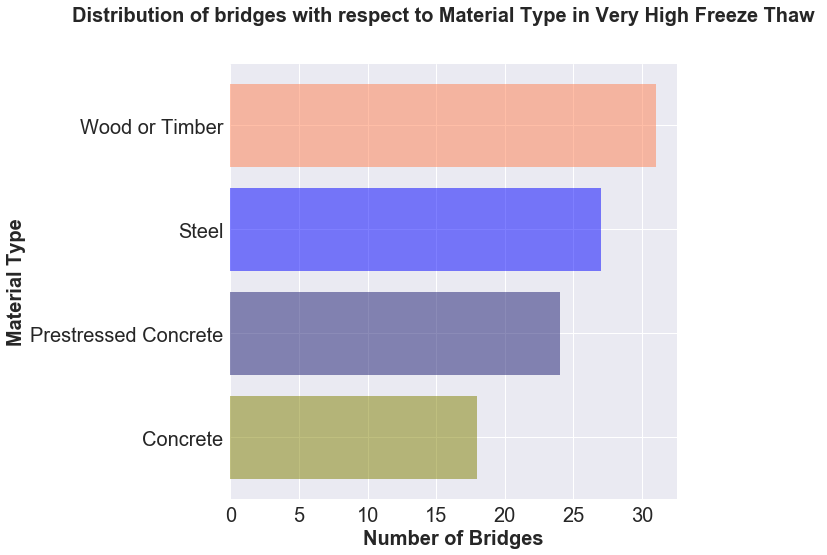

In [22]:
scores_high = freezethaw_small[freezethaw_small['freezethaw'] == 'Very High']
scores_high['materialname'] = retMaterialNames(scores_high['material'])

low_mat = scores_high[scores_high['materialname'].isin(["Wood or Timber","Concrete", "Steel","Prestressed Concrete"])]
count_mat = low_mat.groupby('materialname')['score'].count()

# Plotting 
plt.figure(figsize=(8,8))
plt.suptitle("Distribution of bridges with respect to Material Type in Very High Freeze Thaw ", fontsize = 20, fontweight = 'bold')
sns.set(font_scale=2)


labels = ["Concrete", "Prestressed Concrete",\
          "Steel", "Wood or Timber"]

no_of_records = count_mat
plt.barh(labels, no_of_records, align = 'center', alpha = 0.5, color = ['olive','midnightblue','blue','coral'])
plt.xticks(size = 20, rotation = 0)
plt.yticks(size = 20)
plt.ylabel("Material Type", fontweight = 'bold', fontsize = 20)
plt.xlabel("Number of Bridges", fontweight = 'bold', fontsize = 20)
plt.show()

### Very Low Freezethaw

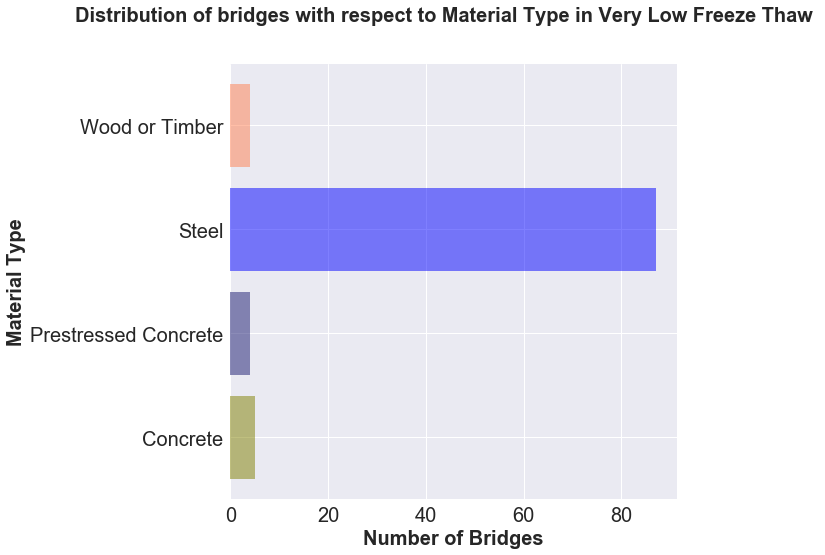

In [23]:
scores_low = freezethaw_small[freezethaw_small['freezethaw'] == 'Very Low']
scores_low['materialname'] = retMaterialNames(scores_low['material'])

low_mat = scores_low[scores_low['materialname'].isin(["Wood or Timber","Concrete", "Steel","Prestressed Concrete"])]
count_mat = low_mat.groupby('materialname')['score'].count()

# Plotting 
plt.figure(figsize=(8,8))
plt.suptitle("Distribution of bridges with respect to Material Type in Very Low Freeze Thaw ", fontsize = 20, fontweight = 'bold')
sns.set(font_scale=2)


labels = ["Concrete", "Prestressed Concrete",\
          "Steel", "Wood or Timber"]

no_of_records = count_mat
plt.barh(labels, no_of_records, align = 'center', alpha = 0.5, color = ['olive','midnightblue','blue','coral'])
plt.xticks(size = 20, rotation = 0)
plt.yticks(size = 20)
plt.ylabel("Material Type", fontweight = 'bold', fontsize = 20)
plt.xlabel("Number of Bridges", fontweight = 'bold', fontsize = 20)
plt.show()

### Count of the bridges with respect to material name with very high number of Freeze Thaw



In [24]:
scores_high.groupby('materialname')['materialname'].count()


materialname
Concrete                18
Prestressed Concrete    24
Steel                   27
Wood or Timber          31
Name: materialname, dtype: int64

### Count of the bridges with respect to material name with very low number of Freeze Thaw

In [25]:
scores_low.groupby('materialname')['materialname'].count()

materialname
Concrete                 5
Prestressed Concrete     4
Steel                   87
Wood or Timber           4
Name: materialname, dtype: int64

## Analysis of Steel Bridges

In [26]:
df_steel = df_anova[df_anova['materialname'] == 'Steel']

### Count of Steel Bridges with repect to freezethaw

In [27]:
df_steel.groupby('freezethaw')['freezethaw'].count()

freezethaw
Very Low      275
Medium       4222
Very High      99
Name: freezethaw, dtype: int64

### Small sample analysis on Steel bridges 

In [28]:
freezethaw_small = df_steel.groupby('freezethaw').apply(lambda s: s.sample(99))
freezethaw = df_steel.groupby('freezethaw').apply(lambda s: s.sample(99))['freezethaw'].tolist()
score = df_steel.groupby('freezethaw').apply(lambda s: s.sample(99))['score'].tolist()
df_freezethaw_sample_100 = pd.DataFrame({'freezethaw':freezethaw, 'score':score})
df_freezethaw_100 = df_freezethaw_sample_100[df_freezethaw_sample_100['freezethaw'].isin(['Very Low', 'Very High'])]

formula = 'score ~ C(freezethaw)'
freezethaw_undersample = undersample(df_freezethaw_100, 'freezethaw')
aov(freezethaw_undersample, formula)

,sum_sq,df,F,PR(>F),eta_sq,omega_sq
C(freezethaw),48.692054,1.0,65.491428,6.023146e-14,0.250453,0.24569
Residual,145.723539,196.0,NaN,NaN,NaN,NaN


#### Cohen's d: 1.34 (Very Large)

## Correlation between Average Daily Traffic and Freeze Thaw

In [29]:
df_high_low = df_anova[df_anova['freezethaw'].isin(['Very Low', 'Very High'])]
df_high_low = df_high_low[['aadtt','numfreezethaw']]
df_high_low.corr()

,aadtt,numfreezethaw
aadtt,1.000000,-0.101505
numfreezethaw,-0.101505,1.000000


## Mapping bridges with low and high freezethaw cycle

### County with number of bridges in Very Low and Very High Freethaw

In [78]:
mapping = df_wo[df_wo['State Code'] == 31]
mapping['SN'] = [structureNumber[:-2] for structureNumber in NE['Structure Number']]
mapping['No. of Freeze Thaw'] = mapping['SN'].map(d_freeze_thaw)
mapping['county'] = mapping['SN'].map(d_structureNumber_county)
mapping = mapping.dropna()
mapping['county'] = [county[0] for county in mapping['county']]
mapping['label'] = pd.qcut(mapping['No. of Freeze Thaw'],[0, .05, .95, 1.], labels = ['Very Low','Medium','Very High'])
mapping = mapping[mapping['label'].isin(['Very Low', 'Very High'])]

In [90]:
map_label_county = mapping.groupby(['label','county'])['Structure Number'].count().dropna()
map_label_county

label      county             
Very Low   Cass County             31
           Dakota County           26
           Douglas County          20
           Gage County             27
           Nemaha County           82
           Otoe County             44
           Pawnee County           88
           Richardson County      114
           Sarpy County            24
           Thurston County          5
Very High  Banner County           11
           Box Butte County         5
           Chase County             8
           Cherry County            4
           Cheyenne County         47
           Dawes County            45
           Deuel County            27
           Garden County           13
           Hooker County            1
           Keith County            27
           Kimball County          24
           Lincoln County          30
           Morrill County          25
           Scotts Bluff County    125
           Sheridan County          8
           Sioux Co

### County with mean baseline difference score of the bridges in Very Low and Very High Freethaw

In [93]:
mapping.groupby(['label', 'county'])['Baseline Difference Score'].mean()

label      county             
Very Low   Cass County            0.053362
           Dakota County          0.193135
           Douglas County         0.240494
           Gage County            0.250486
           Nemaha County         -0.591140
           Otoe County            0.125908
           Pawnee County         -0.471580
           Richardson County     -0.127696
           Sarpy County           0.829369
           Thurston County        0.330197
Very High  Banner County          0.855671
           Box Butte County       0.791149
           Chase County           0.490457
           Cherry County         -0.841692
           Cheyenne County        0.632264
           Dawes County           0.253426
           Deuel County           0.279768
           Garden County          0.762726
           Hooker County         -0.209837
           Keith County           0.788467
           Kimball County         0.604472
           Lincoln County         0.661828
           Morrill Coun